In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

from model import ViTModel
from data_utils import CIFARDataLoader
from calibration import TemperatureScaling, EnsembleTemperatureScaling
from test_eval import get_logits_and_labels, get_all_metrics, reliability_diagram
from train import train_model

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"Using device: {device}")

Using device: cuda


In [4]:
data_loader = CIFARDataLoader(batch_size=64, num_workers=2)

train_loader, val_loader, test_loader = data_loader.get_data_loaders()

print(len(train_loader), len(val_loader), len(test_loader))

100%|██████████| 170M/170M [00:04<00:00, 42.3MB/s]


625 157 157


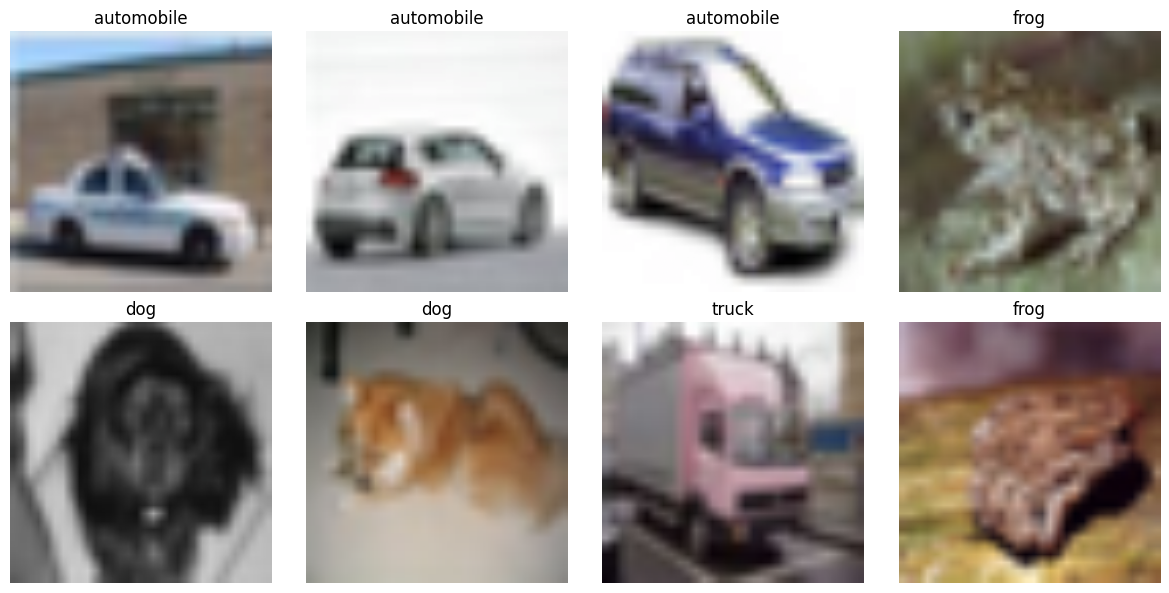

In [5]:
images, labels = next(iter(train_loader))

fig, axes = plt.subplots(2, 4, figsize=(12, 6))
axes = axes.ravel()

for i in range(min(8, len(images))):
    image = images[i]
    label = labels[i]

    if isinstance(image, torch.Tensor):
        mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
        std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
        image = image * std + mean
        image = torch.clamp(image, 0, 1)

        image = image.permute(1, 2, 0).numpy()

    axes[i].imshow(image)
    axes[i].set_title(f"{data_loader.class_names[label]}")
    axes[i].axis("off")

plt.tight_layout()
plt.show()

In [8]:
model = ViTModel("google/vit-base-patch16-224", num_classes=10)

model = model.to(device)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([10]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([10, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [9]:
num_epochs = 5
learning_rate = 1e-4
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=0.01)
criterion = nn.CrossEntropyLoss()

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

train_losses, val_losses, train_accuracies, val_accuracies = train_model(
    model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs, device
)

Epoch 1/5: 100%|██████████| 625/625 [07:10<00:00,  1.45it/s, Loss=0.4950, Acc=83.38%]


Epoch [1/5]:
  Train Loss: 0.6892, Train Acc: 83.38%
  Val Loss: 0.3479, Val Acc: 90.56%
  Learning Rate: 0.000090



Epoch 2/5: 100%|██████████| 625/625 [07:12<00:00,  1.44it/s, Loss=0.2401, Acc=91.06%]


Epoch [2/5]:
  Train Loss: 0.3020, Train Acc: 91.06%
  Val Loss: 0.2802, Val Acc: 91.59%
  Learning Rate: 0.000065



Epoch 3/5: 100%|██████████| 625/625 [07:13<00:00,  1.44it/s, Loss=0.2468, Acc=91.96%]


Epoch [3/5]:
  Train Loss: 0.2613, Train Acc: 91.96%
  Val Loss: 0.2586, Val Acc: 92.02%
  Learning Rate: 0.000035



Epoch 4/5: 100%|██████████| 625/625 [07:13<00:00,  1.44it/s, Loss=0.2118, Acc=92.38%]


Epoch [4/5]:
  Train Loss: 0.2451, Train Acc: 92.38%
  Val Loss: 0.2501, Val Acc: 92.12%
  Learning Rate: 0.000010



Epoch 5/5: 100%|██████████| 625/625 [07:13<00:00,  1.44it/s, Loss=0.2279, Acc=92.52%]


Epoch [5/5]:
  Train Loss: 0.2386, Train Acc: 92.52%
  Val Loss: 0.2479, Val Acc: 92.25%
  Learning Rate: 0.000000



In [10]:
logits, labels = get_logits_and_labels(model, test_loader, device)

100%|██████████| 157/157 [01:49<00:00,  1.44it/s]


Accuracy 92.36999750137329
Confidence 89.72100615501404
ECE 2.6489932724833474


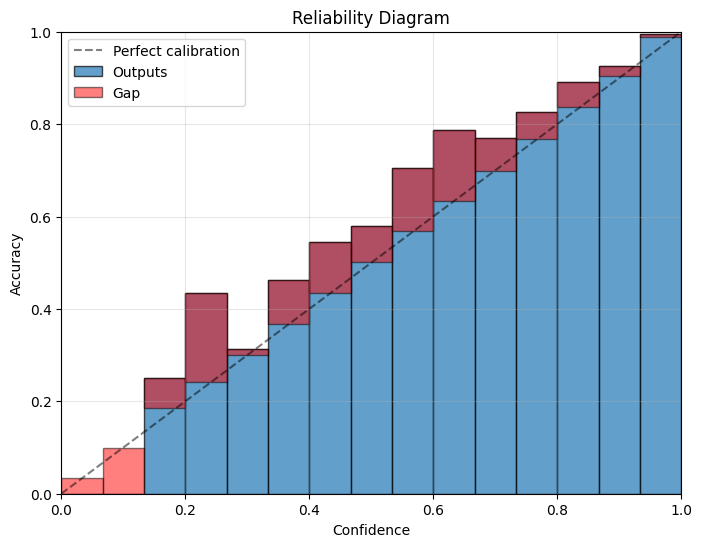

In [24]:
metrics = get_all_metrics(logits, labels)

print("Accuracy", metrics["accuracy"] * 100)
print("Confidence", metrics["confidence"] * 100)
print("ECE", metrics["ece"] * 100)

reliability_diagram(logits, labels)

In [29]:
scaler = TemperatureScaling()

scaler.calibrate(logits, labels, lr=0.01, max_iter=100)

print(scaler.temperature.item())

0.9896044731140137


Accuracy 92.36999750137329
Confidence 89.87002968788147
ECE 2.499971332848071


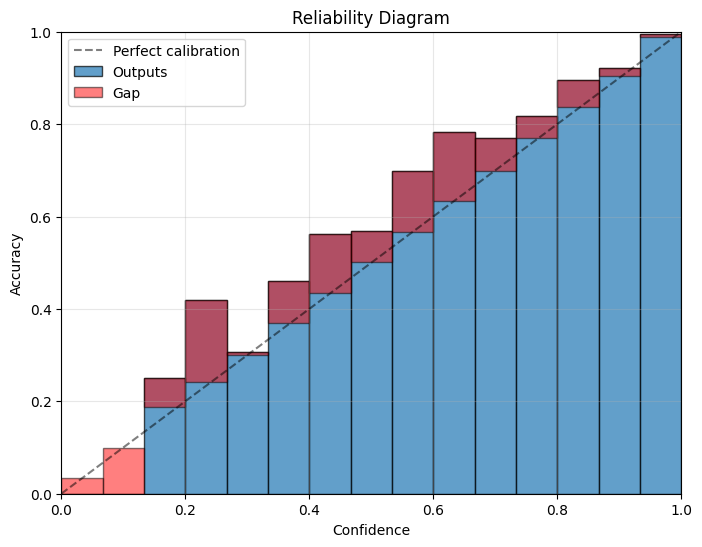

In [30]:
scaled_logits = scaler(logits)

scaled_metrics = get_all_metrics(scaled_logits, labels)

print("Accuracy", scaled_metrics["accuracy"] * 100)
print("Confidence", scaled_metrics["confidence"] * 100)
print("ECE", scaled_metrics["ece"] * 100)

reliability_diagram(scaled_logits, labels)

In [ ]:
ets_scaler = EnsembleTemperatureScaling()

weights = ets_scaler.calibrate(logits, labels, lr=0.01, max_iter=100)

print(ets_scaler.weights)
print(ets_scaler.temperature.item())

Parameter containing:
tensor([0.3333, 0.3333, 0.3334], requires_grad=True)
0.4506293535232544


In [ ]:
ets_scaler = EnsembleTemperatureScaling()

weights = ets_scaler.calibrate(logits, labels, lr=0.01, max_iter=100)

print(ets_scaler.weights)
print(ets_scaler.temperature.item())

Parameter containing:
tensor([0.3333, 0.3333, 0.3334], requires_grad=True)
0.4506293535232544


In [ ]:
ets_scaler = EnsembleTemperatureScaling()

weights = ets_scaler.calibrate(logits, labels, lr=0.01, max_iter=100)

print(ets_scaler.weights)
print(ets_scaler.temperature.item())

Parameter containing:
tensor([0.3333, 0.3333, 0.3334], requires_grad=True)
0.4506293535232544


Accuracy 92.36999750137329
Confidence 90.67270755767822
ECE 1.7085673090815519


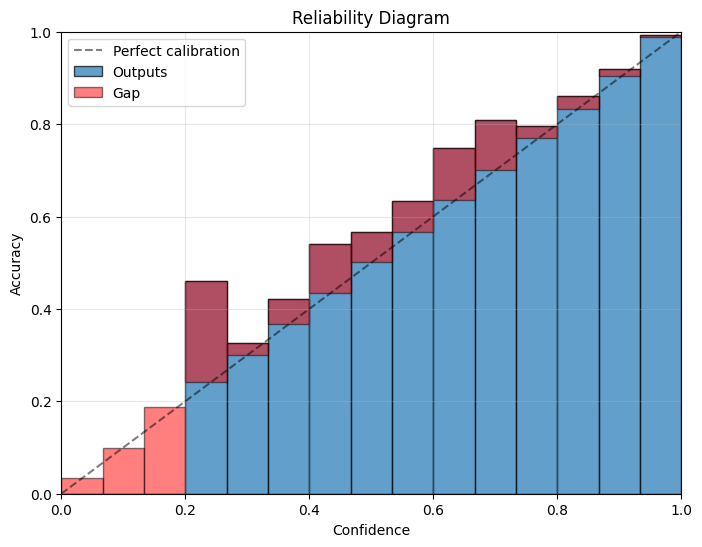

In [32]:
ets_logits = ets_scaler(logits)

ets_metrics = get_all_metrics(ets_logits, labels)

print("Accuracy", ets_metrics["accuracy"] * 100)
print("Confidence", ets_metrics["confidence"] * 100)
print("ECE", ets_metrics["ece"] * 100)

reliability_diagram(ets_logits, labels)